In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords

In [3]:
records = []
for path in sorted(Path("usa-central-bank/fomc-statements").glob("*.txt")):
    records.append({"date": path.stem, "text": path.read_text(encoding="utf-8")})

df = pd.DataFrame(records)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print(f"Loaded {len(df)} statements ({df['date'].min().year}–{df['date'].max().year})")

Loaded 49 statements (2014–2025)


In [4]:
stop_words = set(stopwords.words("english"))
stop_words.update({
    "committee", "federal", "reserve", "percent", "bank",
    "will", "also", "rate", "rates", "fomc"
})

def clean(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = [t for t in text.split() if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

df["clean"] = df["text"].apply(clean)

In [5]:
N_TOPICS = 6

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
dtm = vectorizer.fit_transform(df["clean"])

lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42, max_iter=20)
lda.fit(dtm)

vocab = vectorizer.get_feature_names_out()
for i, component in enumerate(lda.components_):
    top_words = [vocab[j] for j in component.argsort()[-10:][::-1]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: expected, measures, prices, remain, adjustments, gradual, actual, stance, continued, energy
Topic 2: recent, move, carefully, gradually, monitoring, pose, medium, evidence, could, elevated
Topic 3: pace, asset, longerterm, toward, purchases, appropriate, longerrun, consistent, month, likely
Topic 4: levels, measures, toward, consistent, prices, appropriate, near, term, energy, continues
Topic 5: picked, quarter, ongoing, april, diminished, december, edged, although, june, expect
Topic 6: appropriate, goals, stance, continue, incoming, recent, balance, elevated, implications, decided


In [ ]:
# Label topics based on top words and temporal patterns
topic_labels = {
    "topic_1": "Post-liftoff normalization (2016–2018)",
    "topic_2": "Transition signals",
    "topic_3": "QE tapering (2014–2015)",
    "topic_4": "Rate hike transition (2015–2016)",
    "topic_5": "Residual",
    "topic_6": "Inflation tightening cycle (2023–2025)",
}

topic_df = topic_df.rename(columns=topic_labels)

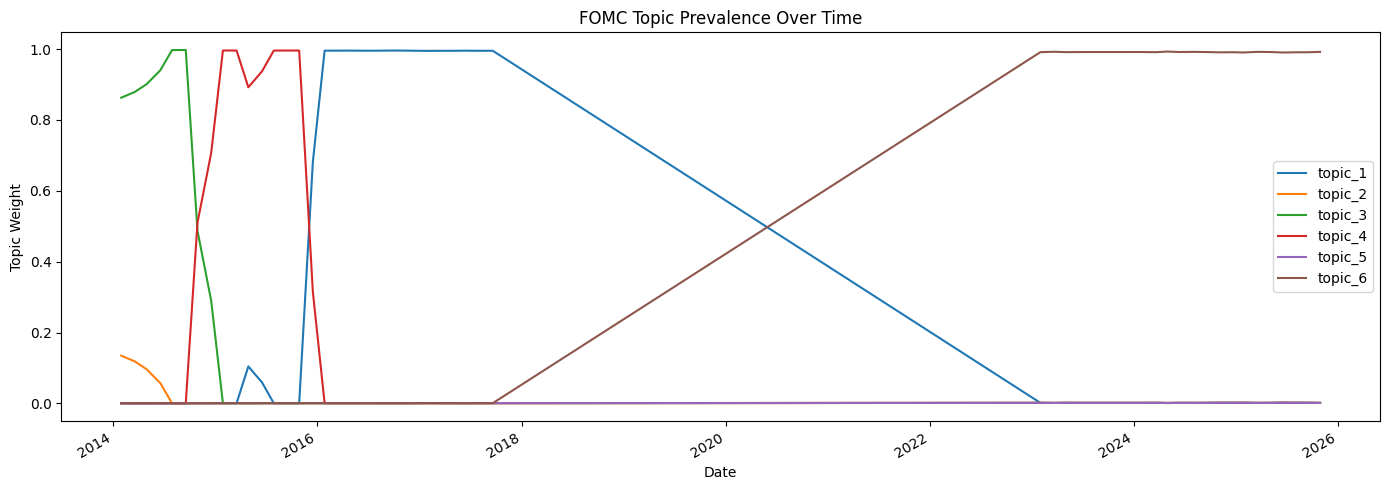

In [6]:
topic_dist = lda.transform(dtm)
topic_cols = [f"topic_{i+1}" for i in range(N_TOPICS)]
topic_df = pd.DataFrame(topic_dist, columns=topic_cols, index=df["date"])

topic_df.plot(figsize=(14, 5), title="FOMC Topic Prevalence Over Time")
plt.xlabel("Date")
plt.ylabel("Topic Weight")
plt.tight_layout()
plt.savefig("fomc_analysis_results.png", dpi=150)
plt.show()

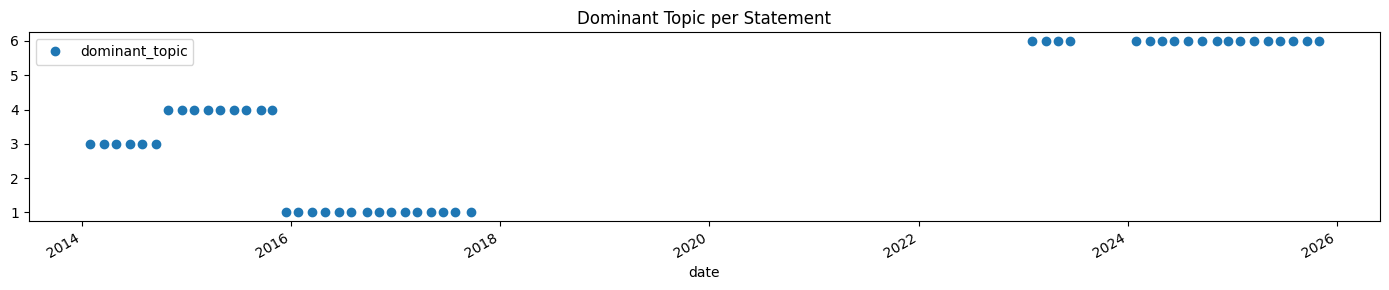

In [ ]:
label_map = {i+1: label for i, label in enumerate(topic_labels.values())}
df["dominant_topic_label"] = df["dominant_topic"].map(label_map)

fig, ax = plt.subplots(figsize=(14, 3))
for topic_num, group in df.groupby("dominant_topic"):
    ax.scatter(group["date"], group["dominant_topic"], label=label_map[topic_num], s=30)

ax.set_yticks(list(label_map.keys()))
ax.set_yticklabels(list(label_map.values()))
ax.set_title("Dominant Topic per Statement")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()